In [1]:
from typing import List, Dict

import numpy as np
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter, get_common_distributions

from src.NoXi.preprocessing.labels_preprocessing import read_noxi_label_file, clean_labels

<h3>Labels loadings</h3>

In [2]:
# engagement_novice(expert).annotation in the directory means that this file is a GOLD STANDARD
# engagement_novice(expert)_*name*.annotation in the directory means that this file is annotated by some *name* rater
# in the directory, it can be several engagement_novice(expert)_*name*.annotation files, meaning that the videofile was annotated by several raters

In [27]:
path_to_labels=r'E:\Databases\NoXi\NoXi_annotations'
gold_standard_paths=glob.glob(os.path.join(path_to_labels,'**','**','engagement_novice.annotation~')) + glob.glob(os.path.join(path_to_labels,'**','**','engagement_expert.annotation~'))
all_paths=glob.glob(os.path.join(path_to_labels,'**','**','*.annotation~'))
all_experts_paths=glob.glob(os.path.join(path_to_labels,'**','**','*expert*.annotation~'))
all_novices_paths=glob.glob(os.path.join(path_to_labels,'**','**','*novice*.annotation~'))

In [28]:
# separate paths according to the filenames
def separate_paths_according_to_filenames(paths:List[str])->Dict[str, List[str]]:
    """Separates provided paths according to the filenames they contain.

    :param paths: List[str]
            List of paths
    :return: Dict[str, List[str]]
            Dictionary of paths in the format Dict[filename->full_path]
    """
    filename_to_paths={}
    for path in paths:
        # extract the filename
        filename=re.search(r"\d+_.*(Nottingham|Paris|Augsburg)", path)
        filename=filename.group()
        # take all paths with this filename
        filename_to_paths[filename]=[item for item in paths if filename in item]
    return filename_to_paths

In [29]:
# function for loading data
def load_annotation_files_by_paths(paths:List[str])->Dict[str, np.ndarray]:
    """Loads NoXi *annotation~ files using provided list of paths

    :param paths: List[str]
            Paths to files for laoding
    :return: List[np.ndarray]
            List of np.ndarrays with labels.
    """
    labels={}
    for path in paths:
        loaded_labels=read_noxi_label_file(path)
        labels[path]=loaded_labels
    return labels

In [30]:
# load labels files
gold_standard_labels=load_annotation_files_by_paths(gold_standard_paths)
all_labels=load_annotation_files_by_paths(all_paths)
all_experts_labels=load_annotation_files_by_paths(all_experts_paths)
all_novices_labels=load_annotation_files_by_paths(all_novices_paths)
# separate paths according to the filenames
gold_standard_paths_separated=separate_paths_according_to_filenames(gold_standard_paths)
all_paths_separated=separate_paths_according_to_filenames(all_paths)
all_experts_paths_separated=separate_paths_according_to_filenames(all_experts_paths)
all_novices_paths_separated=separate_paths_according_to_filenames(all_novices_paths)

In [31]:
# clean labels and delete confidences of labels
def clean_and_delete_confidence(labels:Dict[str, np.ndarray])->Dict[str, np.ndarray]:
    """Cleans and deletes confidences from labels

    :param labels: Dict[str, np.ndarray]
            labels in the format Dict[labels_path(filename)->values]
    :return: Dict[str, np.ndarray]
            cleaned labels with deleted second columns (confidences)
    """
    for key, value in labels.items():
        value=clean_labels(value)
        value=value[:,0].reshape((-1,1))
        labels[key]=value
    return labels

gold_standard_labels=clean_and_delete_confidence(gold_standard_labels)
all_labels=clean_and_delete_confidence(all_labels)
all_experts_labels=clean_and_delete_confidence(all_experts_labels)
all_novices_labels=clean_and_delete_confidence(all_novices_labels)

<h2> Statistical Analysis </h2>

In [8]:
# we have
# gold_standard_labels - labels made as gold standard ONLY (these have not all videofiles)
# all_labels - all existed labels (including gold standard labels). Several videofiles contain several label files
# all_experts_labels - all existed experts labels
# all_novice_labels - all existed novice labels
# gold_standard_paths_separated - paths to gold standard labels separated according to their filenames, so that one filename can contain several paths to the labels
# all_paths - paths all labels separated according to their filenames, so that one filename can contain several paths to the labels
# all_experts_paths - paths to all experts' labels separated according to their filenames, so that one filename can contain several paths to the labels
# all_novice_paths - paths to all novices' labels separated according to their filenames, so that one filename can contain several paths to the labels

<h3> Ranges for every label and Average Range within one videofile </h3>

In [9]:
ranges_all_labels = {key:np.ptp(item) for key, item in all_labels.items()}
ranges_gold_standard_labels = {key:np.ptp(item) for key, item in gold_standard_labels.items()}
ranges_experts_labels = {key:np.ptp(item) for key, item in all_experts_labels.items()}
ranges_novices_labels = {key:np.ptp(item) for key, item in all_novices_labels.items()}

Text(0.5, 1.0, 'Only Novices Labels')

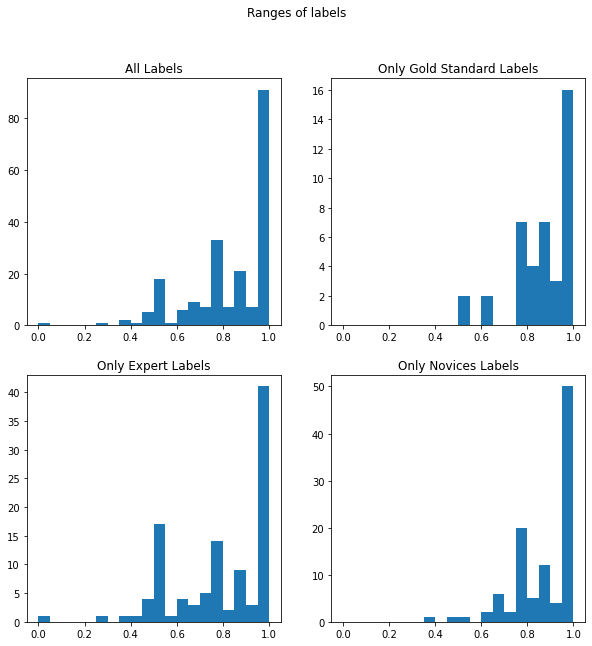

In [10]:
# visualize data
fig, axs = plt.subplots(2,2, figsize=(10, 10))
fig.suptitle('Ranges of labels')
axs[0,0].hist(np.array(list(ranges_all_labels.values())), bins=20, range=(0,1))
axs[0,0].set_title("All Labels")
axs[0,1].hist(np.array(list(ranges_gold_standard_labels.values())), bins=20, range=(0,1))
axs[0,1].set_title("Only Gold Standard Labels")
axs[1,0].hist(np.array(list(ranges_experts_labels.values())), bins=20, range=(0,1))
axs[1,0].set_title("Only Expert Labels")
axs[1,1].hist(np.array(list(ranges_novices_labels.values())), bins=20, range=(0,1))
axs[1,1].set_title("Only Novices Labels")

In [43]:
# what labels have range less than 0.4?
for key, value in ranges_all_labels.items():
    if value < 0.5:
        print(key)

E:\Databases\NoXi\NoXi_annotations\English\032_2016-04-07_Nottingham\engagement_expert_sandra.annotation~
E:\Databases\NoXi\NoXi_annotations\English\048_2016-04-12_Nottingham\engagement_expert_sandra.annotation~
E:\Databases\NoXi\NoXi_annotations\German\067_2016-05-23_Augsburg\engagement_expert_sandra.annotation~
E:\Databases\NoXi\NoXi_annotations\German\072_2016-05-23_Augsburg\engagement_expert_sandra.annotation~
E:\Databases\NoXi\NoXi_annotations\German\074_2016-05-23_Augsburg\engagement_expert_leon.annotation~
E:\Databases\NoXi\NoXi_annotations\German\074_2016-05-23_Augsburg\engagement_novice_leon.annotation~
E:\Databases\NoXi\NoXi_annotations\German\081_2016-05-24_Augsburg\engagement_expert_marc.annotation~
E:\Databases\NoXi\NoXi_annotations\German\084_2016-05-31_Augsburg\engagement_expert_wladislaw.annotation~
E:\Databases\NoXi\NoXi_annotations\German\084_2016-05-31_Augsburg\engagement_novice_wladislaw.annotation~
E:\Databases\NoXi\NoXi_annotations\Others\055_2016-04-14_Nottingham

In [45]:
ranges_all_labels["E:\\Databases\\NoXi\\NoXi_annotations\\French\\012_2016-03-25_Paris\\engagement_novice.annotation~"]


KeyError: 'E:\\Databases\\NoXi\\NoXi_annotations\\French\\012_2016-03-25_Paris\\engagement_novice.annotation~'

In [46]:
ranges_all_labels

{'E:\\Databases\\NoXi\\NoXi_annotations\\English\\026_2016-04-06_Nottingham\\engagement_expert.annotation~': 0.528935,
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\026_2016-04-06_Nottingham\\engagement_novice.annotation~': 0.80130404,
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\027_2016-04-06_Nottingham\\engagement_expert.annotation~': 0.75,
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\027_2016-04-06_Nottingham\\engagement_novice.annotation~': 1.0,
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\028_2016-04-06_Nottingham\\engagement_expert.annotation~': 0.546674,
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\028_2016-04-06_Nottingham\\engagement_novice.annotation~': 0.625814,
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\029_2016-04-06_Nottingham\\engagement_expert_jonas.annotation~': 1.0,
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\029_2016-04-06_Nottingham\\engagement_expert_leon.annotation~': 1.0,
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\029_

In [12]:
# average range
print("Average range for all labels:%f"%(np.array(list(ranges_all_labels.values()))).mean())
print("Average range for gold standard labels:%f"%(np.array(list(ranges_gold_standard_labels.values()))).mean())
print("Average range for all experts labels:%f"%(np.array(list(ranges_experts_labels.values()))).mean())
print("Average range for all novices labels:%f"%(np.array(list(ranges_novices_labels.values()))).mean())

Average range for all labels:0.831562
Average range for gold standard labels:0.868969
Average range for all experts labels:0.784449
Average range for all novices labels:0.879250


In [18]:
# what if take only labels with 3 raters or more?
ranges_all_labels_truncated = {key:value for key,value in ranges_all_labels.items() if len(value)>3}
fig, axs = plt.subplots(1,1, figsize=(10, 10))
fig.suptitle('Ranges of labels of video with no less than 3 raters')
axs[0,0].hist(np.array(list(ranges_all_labels_truncated.values())), bins=20, range=(0,1))


TypeError: object of type 'numpy.float32' has no len()

<h3> Labels Distributions </h3>

In [13]:
# concatenate all values of labels
gold_standard_labels_values=np.concatenate([value for value in gold_standard_labels.values()], axis=0)
all_labels_values=np.concatenate([value for value in all_labels.values()], axis=0)
all_experts_labels_values=np.concatenate([value for value in all_experts_labels.values()], axis=0)
all_novices_labels_values=np.concatenate([value for value in all_novices_labels.values()], axis=0)

Text(0.5, 1.0, 'Only Novices Labels')

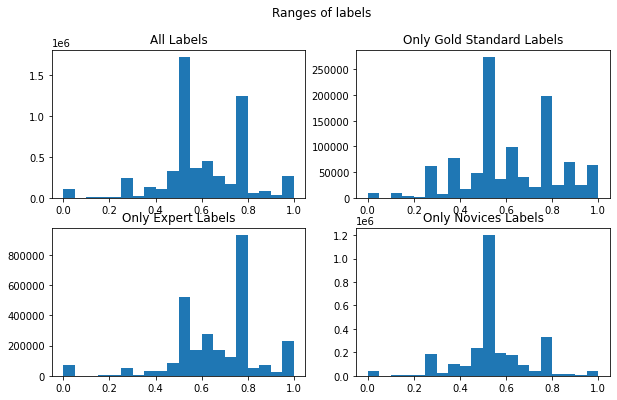

In [14]:
# graphics of labels distribution
fig, axs = plt.subplots(2,2, figsize=(10, 6))
fig.suptitle('Ranges of labels')
axs[0,0].hist(all_labels_values, bins=20, range=(0,1))
axs[0,0].set_title("All Labels")
axs[0,1].hist(gold_standard_labels_values, bins=20, range=(0,1))
axs[0,1].set_title("Only Gold Standard Labels")
axs[1,0].hist(all_experts_labels_values, bins=20, range=(0,1))
axs[1,0].set_title("Only Expert Labels")
axs[1,1].hist(all_novices_labels_values, bins=20, range=(0,1))
axs[1,1].set_title("Only Novices Labels")

,sumsquare_error,aic,bic,kl_div
chi2,947.150425,125.887754,-4.909654e+07,0.873685
norm,947.232723,116.464045,-4.909606e+07,0.865619
gamma,947.422626,124.049774,-4.909491e+07,0.878530
cauchy,959.851169,133.603295,-4.902132e+07,0.812944
exponpow,959.996481,64.024632,-4.902045e+07,1.020935


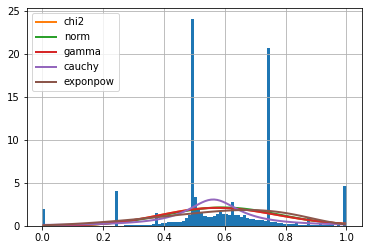

In [15]:
# check which distribution the data has
f = Fitter(all_labels_values, timeout=180, distributions=get_common_distributions())
f.fit()
f.summary()

In [16]:
f.fitted_param["norm"]

(0.59393644, 0.18676536)

All labels size: 5647641
(0.59393644, 0.18676536)


In [29]:
from scipy import stats

# do K-S-test for all distributions
list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']

results = []
for i in list_of_dists:
    dist = getattr(stats, i)
    param = dist.fit(all_labels_values.flatten())
    a = stats.kstest(all_labels_values.flatten(), i, args=param)
    results.append((i,a[0],a[1]))


results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

<ipython-input-29-c3fa15bb6b48>:9: DeprecationWarning: `frechet_r` is deprecated!
The distribution `frechet_r` is a synonym for `weibull_min`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_min`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
  param = dist.fit(all_labels_values.flatten())
<ipython-input-29-c3fa15bb6b48>:9: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
  param = dist.fit(all_labels_values.flatten())


KeyboardInterrupt: 

Text(0.5, 1.0, 'Only Novices Labels')

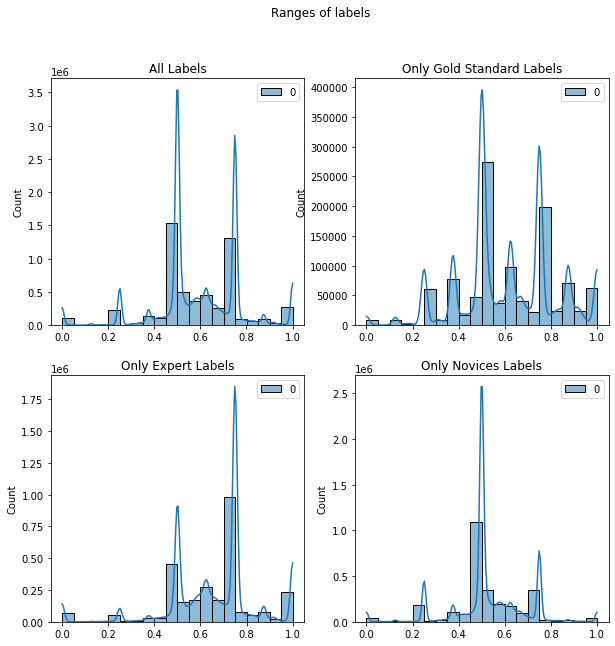

In [21]:
# graphics of labels distribution
fig, axs = plt.subplots(2,2, figsize=(10, 10))
fig.suptitle('Ranges of labels')

sns.histplot(all_labels_values, kde=True, ax=axs[0,0], bins=20)
sns.histplot(gold_standard_labels_values,kde=True, ax=axs[0,1], bins=20)
sns.histplot(all_experts_labels_values, kde=True, ax=axs[1,0], bins=20)
sns.histplot(all_novices_labels_values, kde=True, ax=axs[1,1], bins=20)

axs[0,0].set_title("All Labels")
axs[0,1].set_title("Only Gold Standard Labels")
axs[1,0].set_title("Only Expert Labels")
axs[1,1].set_title("Only Novices Labels")

<h3> Variability of the raters' annotations within one video </h3>

In [41]:
len([item for item in gold_standard_paths if "Paris" in item])

24

In [35]:
len(all_paths)

210

In [42]:
gold_standard_paths

['E:\\Databases\\NoXi\\NoXi_annotations\\English\\026_2016-04-06_Nottingham\\engagement_novice.annotation~',
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\027_2016-04-06_Nottingham\\engagement_novice.annotation~',
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\028_2016-04-06_Nottingham\\engagement_novice.annotation~',
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\030_2016-04-06_Nottingham\\engagement_novice.annotation~',
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\034_2016-04-07_Nottingham\\engagement_novice.annotation~',
 'E:\\Databases\\NoXi\\NoXi_annotations\\English\\052_2016-04-12_Nottingham\\engagement_novice.annotation~',
 'E:\\Databases\\NoXi\\NoXi_annotations\\French\\001_2016-03-17_Paris\\engagement_novice.annotation~',
 'E:\\Databases\\NoXi\\NoXi_annotations\\French\\002_2016-03-17_Paris\\engagement_novice.annotation~',
 'E:\\Databases\\NoXi\\NoXi_annotations\\French\\003_2016-03-17_Paris\\engagement_novice.annotation~',
 'E:\\Databases\\NoXi\\NoXi_annotatio